<a href="https://colab.research.google.com/github/rajagopalmotivate/try1/blob/master/DCGAN_with_2_different_generators_and_1_Classifier_ver7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from keras.datasets import mnist
from keras.datasets import fashion_mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate, Average
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Model
from keras.optimizers import Adam
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model
from google.colab import files


In [0]:
##!wget "https://github.com/rajagopalmotivate/DeepLearnIITMA1/blob/master/model2001s%20(1).h5"

In [0]:
def load_dataold():
    (X_train, _), (_, _) = mnist.load_data()
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3)
    return X_train

In [0]:
def load_large_data():
    (X_train1, _), (_, _) = mnist.load_data()
    (X_train2, _), (_, _) = fashion_mnist.load_data()
    
    X_trainlarge = np.zeros([10000,56,56],dtype=np.uint8)
    
    for i in range(0, 100):
      for j in range(0, 100):    
          aimage1 = X_train2[i]
          aimage2 = X_train2[j]
          largeimage =  np.zeros([56,56],dtype=np.uint8)
          largeimage[0:56, 0:56] = 40
          largeimage[0:28, 0:28] = aimage2
          largeimage[0:28, 28:56] = aimage1
          X_trainlarge[i*100 + j] = largeimage
 
    
    fig=plt.figure(figsize=(16, 16))
    for i in range(0, 10):
      for j in range(0, 10):
          fig.add_subplot(10, 10, i*10 + j +1)
          plt.imshow(X_trainlarge[i*100 + j + 1000])
  ##plt.show()
    
    print(X_train2.shape)
    print(X_trainlarge.shape)
    
    plt.imshow(aimage1)
    plt.show()  
 
    plt.imshow(aimage2)
    plt.show()
    
    plt.imshow(largeimage, interpolation='none')
    plt.show()
    

    X_trainlarge = (X_trainlarge.astype(np.float32) - 127.5) / 127.5
    X_trainlarge = np.expand_dims(X_trainlarge, axis=3)


    return X_trainlarge

(60000, 28, 28)
(10000, 56, 56)


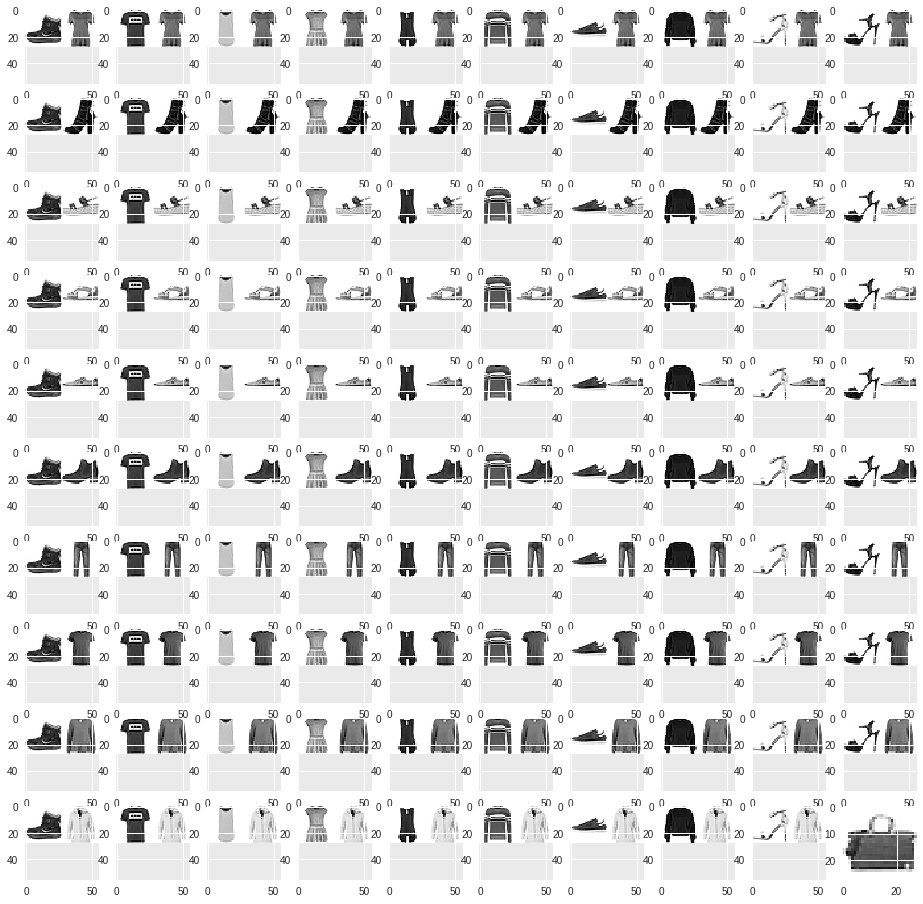

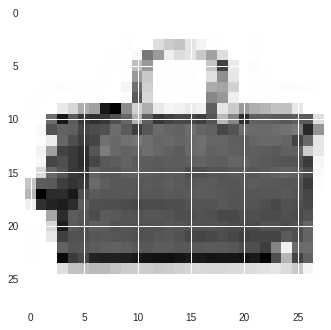

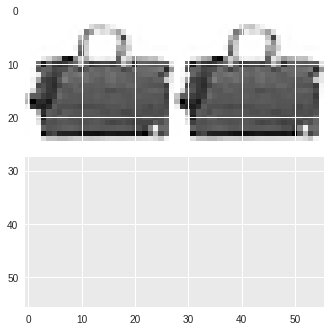

In [42]:
X_trainlarge = load_large_data()

In [0]:
def load_databydatasetname(datasetname):
  if (datasetname == 1):   
    (X_train, _), (_, _) = mnist.load_data()
  if (datasetname == 2):   
    (X_train, _), (_, _) = fashion_mnist.load_data()
  X_train = (X_train.astype(np.float32) - 127.5) / 127.5
  X_train = np.expand_dims(X_train, axis=3)
  return X_train
  

In [0]:
def build_generator(noise_shape=(100,)):
    input = Input(noise_shape)
    x = Dense(128 * 7 * 7, activation="relu")(input)
    x = Reshape((7, 7, 128))(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(128, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(64, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(1, kernel_size=3, padding="same")(x)
    out = Activation("tanh")(x)
    model = Model(input, out)
    print("-- Generator -- ")
    model.summary()
    return model

In [0]:
def build_discriminator(img_shape):
    input = Input(img_shape)
    x =Conv2D(32, kernel_size=3, strides=2, padding="same")(input)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = Conv2D(64, kernel_size=3, strides=2, padding="same")(x)
    x = ZeroPadding2D(padding=((0, 1), (0, 1)))(x)
    x = (LeakyReLU(alpha=0.2))(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(128, kernel_size=3, strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(256, kernel_size=3, strides=1, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    out = Dense(1, activation='sigmoid')(x)

    model = Model(input, out)
    print("-- Discriminator -- ")
    model.summary()
    return model

In [0]:
def save_imgs(generator, epoch, batch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    ##fig.savefig("images/mnist_%d_%d.png" % (epoch, batch))
    plt.show()
    plt.close()

In [0]:
def build_generator_model():

    gen_optimizer = Adam(lr=0.0002, beta_1=0.5)
 
    generator = build_generator()
    generator.compile(loss='binary_crossentropy', optimizer=gen_optimizer)

  
    return generator

In [0]:
def train(generator1, generator2, discriminator, combined, epochs=2000, batch_size=128, save_interval=50):

    X_train = load_databydatasetname(1)

    num_examples = X_train.shape[0]/4
    num_batches = int(num_examples / float(batch_size))
    print('Number of examples: ', num_examples)
    print('Number of Batches: ', num_batches)
    print('Number of epochs: ', epochs)

    half_batch = int(batch_size / 2)
    quater_batch = int(half_batch / 2) 

    for epoch in range(epochs + 1):
        for batch in range(num_batches):

            # noise images for the batch
            noise1 = np.random.normal(0, 1, (quater_batch, 100))
            fake_images1 = generator1.predict(noise1)
            fake_labels1 = np.zeros((quater_batch, 1))
            
            noise2 = np.random.normal(0, 1, (quater_batch, 100))
            fake_images2 = generator1.predict(noise2)
            fake_labels2 = np.zeros((quater_batch, 1))
            
            fake_images = np.append(fake_images1 , fake_images2, axis=0)
            fake_labels = np.append( fake_labels1 , fake_labels2, axis=0)
            
            if(batch == 0):
              print("G1 output numpy array shape")
              print(fake_images1.shape)
              print("G1+G2 appended numpy array shape")
              print(fake_images.shape)

            # real images for batch
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            real_images = X_train[idx]
            real_labels = np.ones((half_batch, 1))

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = discriminator.train_on_batch(real_images, real_labels)
            d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            noise = np.random.normal(0, 1, (batch_size, 100))
            # Train the generator
            g_loss = combined.train_on_batch(noise, np.ones((batch_size, 1)))

            # Plot the progress
            print("Epoch %d Batch %d/%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (epoch,batch, num_batches, d_loss[0], 100 * d_loss[1], g_loss))

            if batch % 50 == 0:
                save_imgs(generator1, epoch, batch)





In [0]:
def build_classifier_model():

    disc_optimizer = Adam(lr=0.0002, beta_1=0.5)


    discriminator = build_discriminator(img_shape=(28, 28, 1))
    discriminator.compile(loss='binary_crossentropy',
                               optimizer=disc_optimizer,
                               metrics=['accuracy'])


    return  discriminator

In [0]:
def build_combined_model():

    discriminatormymodel = build_classifier_model

    generatormymodel = build_generator_model()
   
    optimizer1 = Adam(lr=0.0002, beta_1=0.5)


    z = Input(shape=(100,))
    img = generatormymodel(z)
    discriminatormymodel.trainable = False
    real = discriminatormymodel(img)
    
    combined = Model(z, real)
    
    combined.compile(loss='binary_crossentropy', optimizer=optimizer1)
    return combined

In [0]:
def getlastlayer(amodel):
  for layer in amodel.layers:
    layerlast = layer
  print(layer)
  print(layer.get_config())
  print(layer.input)
  print(layer.input_shape)
  print(layer.output)
  print('output shape of last is ')
  print(layer.output_shape)
  return layer

In [0]:
def build_models():

    gen1_optimizer = Adam(lr=0.0002, beta_1=0.5)
    gen2_optimizer = Adam(lr=0.0002, beta_1=0.5)
    disc_optimizer = Adam(lr=0.0002, beta_1=0.5)


    discriminator = build_discriminator(img_shape=(28, 28, 1))
    discriminator.compile(loss='binary_crossentropy', optimizer=disc_optimizer,  metrics=['accuracy'])

    generator1 = build_generator()
    
    generator2 = build_generator()

    z = Input(shape=(100,))
    img1 = generator1(z)
    img2 = generator2(z)
    merged = Average(getlastlayer(img1).output, getlastlayer(img2).output)
    discriminator.trainable = False
    real = discriminator(merged)
    combined = Model(z, real)
    
    combined.summary()
    
    generator1.compile(loss='binary_crossentropy', optimizer=gen1_optimizer)
    generator2.compile(loss='binary_crossentropy', optimizer=gen2_optimizer)
    
    combined.compile(loss='binary_crossentropy', optimizer=gen_optimizer)
    return generator, discriminator, combined

In [0]:
def build_modelsNEW():
    z = Input(shape=(100,))
    inputz = z
    x = Dense(128 * 7 * 7, activation="relu")(inputz)
    x = Reshape((7, 7, 128))(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(128, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(64, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(1, kernel_size=3, padding="same")(x)
    out = Activation("tanh")(x)    
    generator1 = Model(inputz, out)
    
    inputz2 = z
    x1 = Dense(128 * 7 * 7, activation="relu")(inputz2)
    x1 = Reshape((7, 7, 128))(x1)
    x1 = BatchNormalization(momentum=0.8)(x1)
    x1 = UpSampling2D()(x1)
    x1 = Conv2D(128, kernel_size=3, padding="same")(x1)
    x1 = Activation("relu")(x1)
    x1 = BatchNormalization(momentum=0.8)(x1)
    x1 = UpSampling2D()(x1)
    x1 = Conv2D(64, kernel_size=3, padding="same")(x1)
    x1 = Activation("relu")(x1)
    x1 = BatchNormalization(momentum=0.8)(x1)
    x1 = Conv2D(1, kernel_size=3, padding="same")(x1)
    out1 = Activation("tanh")(x1)    
    generator2 = Model(inputz2, out1)
    
    
    img1 = generator1(z)
    img2 = generator2(z)
    
    
    aoptimizer = Adam(lr=0.0002, beta_1=0.5)   
    discriminator = build_discriminator(img_shape=(28, 28, 1))
    discriminator.compile(loss='binary_crossentropy', optimizer=aoptimizer,  metrics=['accuracy'])
    
    models = [generator1, generator2]
 ##   models = [generator1, generator1]
    outputs = [model.outputs[0] for model in models]
    merged = Average()(outputs)
    discriminator.trainable = False
    real = discriminator(merged)
    combined = Model(z, real)
        
    generator1.compile(loss='binary_crossentropy', optimizer=aoptimizer)
    generator2.compile(loss='binary_crossentropy', optimizer=aoptimizer)  
    combined.compile(loss='binary_crossentropy', optimizer=aoptimizer)
    
    return generator1, generator2, discriminator, combined ,  

In [54]:
generator1, generator2, discriminator, combined = build_modelsNEW()


    
    

    


-- Discriminator -- 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 8, 8, 64)          0         
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 64)          

Number of examples:  15000.0
Number of Batches:  468
Number of epochs:  1
G1 output numpy array shape
(8, 28, 28, 1)
G1+G2 appended numpy array shape
(16, 28, 28, 1)


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 0 Batch 0/468 [D loss: 0.918375, acc.: 53.12%] [G loss: 0.551699]


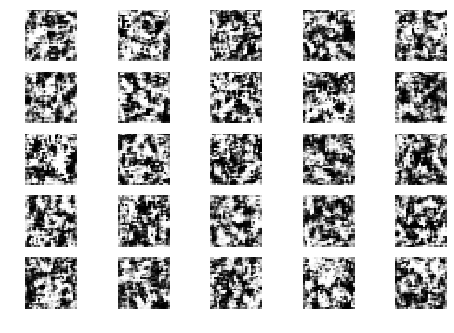

Epoch 0 Batch 1/468 [D loss: 0.875859, acc.: 53.12%] [G loss: 0.491446]
Epoch 0 Batch 2/468 [D loss: 0.605085, acc.: 62.50%] [G loss: 0.859144]
Epoch 0 Batch 3/468 [D loss: 0.491106, acc.: 71.88%] [G loss: 0.963484]
Epoch 0 Batch 4/468 [D loss: 0.444364, acc.: 84.38%] [G loss: 1.069674]
Epoch 0 Batch 5/468 [D loss: 0.378162, acc.: 87.50%] [G loss: 1.308571]
Epoch 0 Batch 6/468 [D loss: 0.341235, acc.: 87.50%] [G loss: 1.270751]
Epoch 0 Batch 7/468 [D loss: 0.322441, acc.: 90.62%] [G loss: 1.322356]
Epoch 0 Batch 8/468 [D loss: 0.266249, acc.: 96.88%] [G loss: 1.582800]
Epoch 0 Batch 9/468 [D loss: 0.275788, acc.: 93.75%] [G loss: 1.352710]
Epoch 0 Batch 10/468 [D loss: 0.230189, acc.: 96.88%] [G loss: 1.373095]
Epoch 0 Batch 11/468 [D loss: 0.229496, acc.: 96.88%] [G loss: 1.321934]
Epoch 0 Batch 12/468 [D loss: 0.220412, acc.: 96.88%] [G loss: 1.229111]
Epoch 0 Batch 13/468 [D loss: 0.221950, acc.: 96.88%] [G loss: 1.264260]
Epoch 0 Batch 14/468 [D loss: 0.212361, acc.: 93.75%] [G los

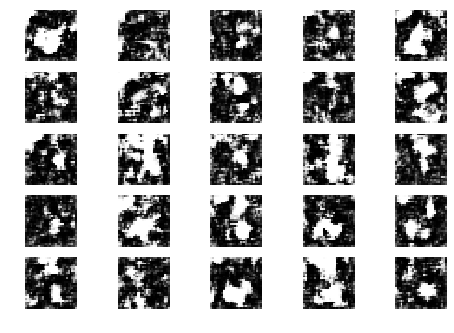

Epoch 0 Batch 51/468 [D loss: 0.335544, acc.: 90.62%] [G loss: 1.046738]
Epoch 0 Batch 52/468 [D loss: 0.148475, acc.: 96.88%] [G loss: 0.760147]
Epoch 0 Batch 53/468 [D loss: 0.108209, acc.: 96.88%] [G loss: 0.666557]
Epoch 0 Batch 54/468 [D loss: 0.084569, acc.: 100.00%] [G loss: 0.759577]
Epoch 0 Batch 55/468 [D loss: 0.124527, acc.: 96.88%] [G loss: 1.573161]
Epoch 0 Batch 56/468 [D loss: 0.305113, acc.: 87.50%] [G loss: 0.399690]
Epoch 0 Batch 57/468 [D loss: 0.067853, acc.: 96.88%] [G loss: 0.468254]
Epoch 0 Batch 58/468 [D loss: 0.095902, acc.: 100.00%] [G loss: 0.583268]
Epoch 0 Batch 59/468 [D loss: 0.159790, acc.: 93.75%] [G loss: 0.465381]
Epoch 0 Batch 60/468 [D loss: 0.057133, acc.: 100.00%] [G loss: 0.886144]
Epoch 0 Batch 61/468 [D loss: 0.077028, acc.: 96.88%] [G loss: 0.301924]
Epoch 0 Batch 62/468 [D loss: 0.065847, acc.: 100.00%] [G loss: 0.212690]
Epoch 0 Batch 63/468 [D loss: 0.274778, acc.: 93.75%] [G loss: 0.897290]
Epoch 0 Batch 64/468 [D loss: 0.015405, acc.: 1

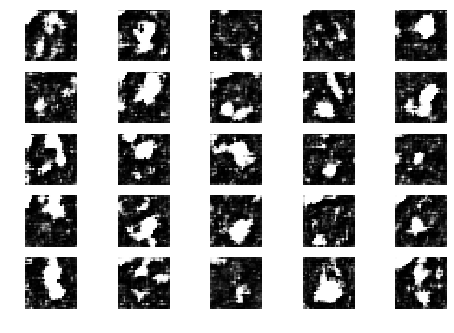

Epoch 0 Batch 101/468 [D loss: 0.031571, acc.: 100.00%] [G loss: 0.017173]
Epoch 0 Batch 102/468 [D loss: 0.007987, acc.: 100.00%] [G loss: 0.050717]
Epoch 0 Batch 103/468 [D loss: 0.023490, acc.: 100.00%] [G loss: 0.091044]
Epoch 0 Batch 104/468 [D loss: 0.163962, acc.: 93.75%] [G loss: 0.009830]
Epoch 0 Batch 105/468 [D loss: 0.114765, acc.: 96.88%] [G loss: 0.072709]
Epoch 0 Batch 106/468 [D loss: 0.020882, acc.: 100.00%] [G loss: 0.063346]
Epoch 0 Batch 107/468 [D loss: 0.013633, acc.: 100.00%] [G loss: 0.131393]
Epoch 0 Batch 108/468 [D loss: 0.010310, acc.: 100.00%] [G loss: 0.048640]
Epoch 0 Batch 109/468 [D loss: 0.034717, acc.: 100.00%] [G loss: 0.019907]
Epoch 0 Batch 110/468 [D loss: 0.186494, acc.: 93.75%] [G loss: 0.035595]
Epoch 0 Batch 111/468 [D loss: 0.020377, acc.: 100.00%] [G loss: 0.031612]
Epoch 0 Batch 112/468 [D loss: 0.006567, acc.: 100.00%] [G loss: 0.045694]
Epoch 0 Batch 113/468 [D loss: 0.009691, acc.: 100.00%] [G loss: 0.020028]
Epoch 0 Batch 114/468 [D los

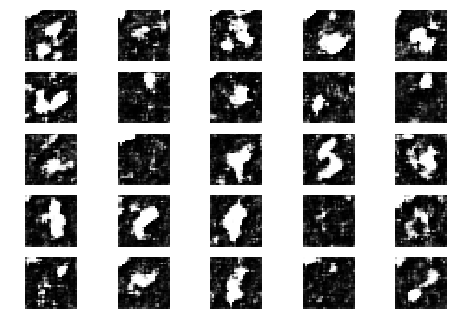

Epoch 0 Batch 151/468 [D loss: 0.071016, acc.: 96.88%] [G loss: 0.042055]
Epoch 0 Batch 152/468 [D loss: 0.003233, acc.: 100.00%] [G loss: 0.020206]
Epoch 0 Batch 153/468 [D loss: 0.071781, acc.: 96.88%] [G loss: 0.006428]
Epoch 0 Batch 154/468 [D loss: 0.002327, acc.: 100.00%] [G loss: 0.000541]
Epoch 0 Batch 155/468 [D loss: 0.020540, acc.: 100.00%] [G loss: 0.004398]
Epoch 0 Batch 156/468 [D loss: 0.046378, acc.: 100.00%] [G loss: 0.003163]
Epoch 0 Batch 157/468 [D loss: 0.003803, acc.: 100.00%] [G loss: 0.001668]
Epoch 0 Batch 158/468 [D loss: 0.005574, acc.: 100.00%] [G loss: 0.001148]
Epoch 0 Batch 159/468 [D loss: 0.027308, acc.: 100.00%] [G loss: 0.001264]
Epoch 0 Batch 160/468 [D loss: 0.060416, acc.: 96.88%] [G loss: 0.004781]
Epoch 0 Batch 161/468 [D loss: 0.031947, acc.: 100.00%] [G loss: 0.011796]
Epoch 0 Batch 162/468 [D loss: 0.060881, acc.: 100.00%] [G loss: 0.002461]
Epoch 0 Batch 163/468 [D loss: 0.008257, acc.: 100.00%] [G loss: 0.000540]
Epoch 0 Batch 164/468 [D los

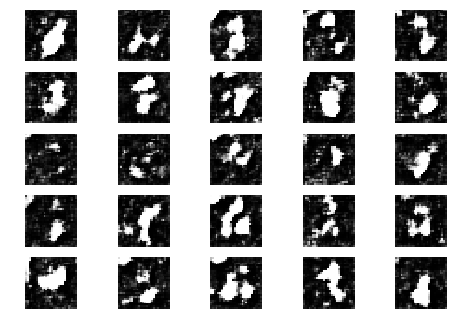

Epoch 0 Batch 201/468 [D loss: 0.009823, acc.: 100.00%] [G loss: 0.000306]
Epoch 0 Batch 202/468 [D loss: 0.158898, acc.: 96.88%] [G loss: 0.000493]
Epoch 0 Batch 203/468 [D loss: 0.001812, acc.: 100.00%] [G loss: 0.004226]
Epoch 0 Batch 204/468 [D loss: 0.000176, acc.: 100.00%] [G loss: 0.012673]
Epoch 0 Batch 205/468 [D loss: 0.010096, acc.: 100.00%] [G loss: 0.003136]
Epoch 0 Batch 206/468 [D loss: 0.094102, acc.: 96.88%] [G loss: 0.000858]
Epoch 0 Batch 207/468 [D loss: 0.012963, acc.: 100.00%] [G loss: 0.003086]
Epoch 0 Batch 208/468 [D loss: 0.164530, acc.: 93.75%] [G loss: 0.013650]
Epoch 0 Batch 209/468 [D loss: 0.020745, acc.: 100.00%] [G loss: 0.010181]
Epoch 0 Batch 210/468 [D loss: 0.335438, acc.: 87.50%] [G loss: 0.000053]
Epoch 0 Batch 211/468 [D loss: 0.150568, acc.: 93.75%] [G loss: 0.000043]
Epoch 0 Batch 212/468 [D loss: 0.021163, acc.: 100.00%] [G loss: 0.001358]
Epoch 0 Batch 213/468 [D loss: 0.000254, acc.: 100.00%] [G loss: 0.001186]
Epoch 0 Batch 214/468 [D loss:

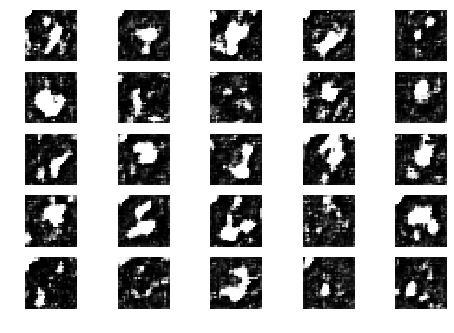

Epoch 0 Batch 251/468 [D loss: 0.008535, acc.: 100.00%] [G loss: 0.000348]
Epoch 0 Batch 252/468 [D loss: 0.000138, acc.: 100.00%] [G loss: 0.000197]
Epoch 0 Batch 253/468 [D loss: 0.000592, acc.: 100.00%] [G loss: 0.000374]
Epoch 0 Batch 254/468 [D loss: 0.059539, acc.: 96.88%] [G loss: 0.000047]
Epoch 0 Batch 255/468 [D loss: 0.005803, acc.: 100.00%] [G loss: 0.000010]
Epoch 0 Batch 256/468 [D loss: 0.158177, acc.: 90.62%] [G loss: 0.000056]
Epoch 0 Batch 257/468 [D loss: 0.012282, acc.: 100.00%] [G loss: 0.003791]
Epoch 0 Batch 258/468 [D loss: 0.000994, acc.: 100.00%] [G loss: 0.003174]
Epoch 0 Batch 259/468 [D loss: 0.011431, acc.: 100.00%] [G loss: 0.003123]
Epoch 0 Batch 260/468 [D loss: 0.001504, acc.: 100.00%] [G loss: 0.004609]
Epoch 0 Batch 261/468 [D loss: 0.020629, acc.: 100.00%] [G loss: 0.000402]
Epoch 0 Batch 262/468 [D loss: 0.016424, acc.: 100.00%] [G loss: 0.001653]
Epoch 0 Batch 263/468 [D loss: 0.060110, acc.: 96.88%] [G loss: 0.000638]
Epoch 0 Batch 264/468 [D los

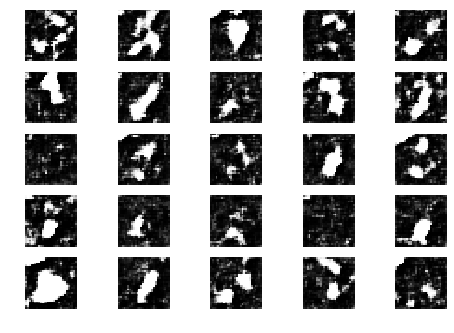

Epoch 0 Batch 301/468 [D loss: 0.020803, acc.: 100.00%] [G loss: 0.001337]
Epoch 0 Batch 302/468 [D loss: 0.016940, acc.: 100.00%] [G loss: 0.014190]
Epoch 0 Batch 303/468 [D loss: 0.004924, acc.: 100.00%] [G loss: 0.005730]
Epoch 0 Batch 304/468 [D loss: 0.000517, acc.: 100.00%] [G loss: 0.001105]
Epoch 0 Batch 305/468 [D loss: 0.000269, acc.: 100.00%] [G loss: 0.015709]
Epoch 0 Batch 306/468 [D loss: 0.001877, acc.: 100.00%] [G loss: 0.004180]
Epoch 0 Batch 307/468 [D loss: 0.003343, acc.: 100.00%] [G loss: 0.000090]
Epoch 0 Batch 308/468 [D loss: 0.001822, acc.: 100.00%] [G loss: 0.004092]
Epoch 0 Batch 309/468 [D loss: 0.000614, acc.: 100.00%] [G loss: 0.000107]
Epoch 0 Batch 310/468 [D loss: 0.001818, acc.: 100.00%] [G loss: 0.000320]
Epoch 0 Batch 311/468 [D loss: 0.000053, acc.: 100.00%] [G loss: 0.002250]
Epoch 0 Batch 312/468 [D loss: 0.004504, acc.: 100.00%] [G loss: 0.001797]
Epoch 0 Batch 313/468 [D loss: 0.006360, acc.: 100.00%] [G loss: 0.001127]
Epoch 0 Batch 314/468 [D 

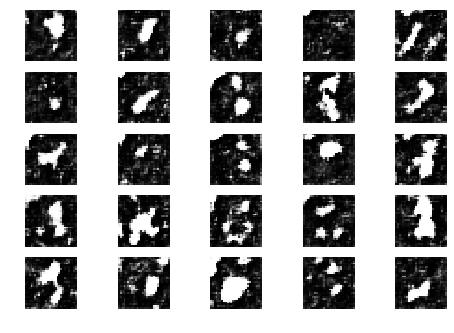

Epoch 0 Batch 351/468 [D loss: 0.000392, acc.: 100.00%] [G loss: 0.000218]
Epoch 0 Batch 352/468 [D loss: 0.004225, acc.: 100.00%] [G loss: 0.000024]
Epoch 0 Batch 353/468 [D loss: 0.011062, acc.: 100.00%] [G loss: 0.000112]
Epoch 0 Batch 354/468 [D loss: 0.000486, acc.: 100.00%] [G loss: 0.000475]
Epoch 0 Batch 355/468 [D loss: 0.000113, acc.: 100.00%] [G loss: 0.000045]
Epoch 0 Batch 356/468 [D loss: 0.000081, acc.: 100.00%] [G loss: 0.000070]
Epoch 0 Batch 357/468 [D loss: 0.000228, acc.: 100.00%] [G loss: 0.000261]
Epoch 0 Batch 358/468 [D loss: 0.001064, acc.: 100.00%] [G loss: 0.000440]
Epoch 0 Batch 359/468 [D loss: 0.000176, acc.: 100.00%] [G loss: 0.000340]
Epoch 0 Batch 360/468 [D loss: 0.001084, acc.: 100.00%] [G loss: 0.009796]
Epoch 0 Batch 361/468 [D loss: 0.001605, acc.: 100.00%] [G loss: 0.000593]
Epoch 0 Batch 362/468 [D loss: 0.001202, acc.: 100.00%] [G loss: 0.000081]
Epoch 0 Batch 363/468 [D loss: 0.004656, acc.: 100.00%] [G loss: 0.000116]
Epoch 0 Batch 364/468 [D 

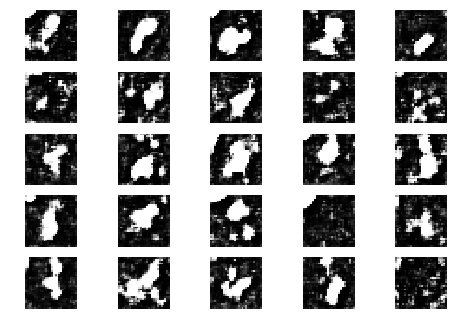

Epoch 0 Batch 401/468 [D loss: 0.000610, acc.: 100.00%] [G loss: 0.000143]
Epoch 0 Batch 402/468 [D loss: 0.000703, acc.: 100.00%] [G loss: 0.000117]
Epoch 0 Batch 403/468 [D loss: 0.002500, acc.: 100.00%] [G loss: 0.000271]
Epoch 0 Batch 404/468 [D loss: 0.029160, acc.: 100.00%] [G loss: 0.000042]
Epoch 0 Batch 405/468 [D loss: 0.002769, acc.: 100.00%] [G loss: 0.000109]
Epoch 0 Batch 406/468 [D loss: 0.114449, acc.: 96.88%] [G loss: 0.000032]
Epoch 0 Batch 407/468 [D loss: 0.001975, acc.: 100.00%] [G loss: 0.000109]
Epoch 0 Batch 408/468 [D loss: 0.000997, acc.: 100.00%] [G loss: 0.003777]
Epoch 0 Batch 409/468 [D loss: 0.049633, acc.: 96.88%] [G loss: 0.000004]
Epoch 0 Batch 410/468 [D loss: 0.000123, acc.: 100.00%] [G loss: 0.000006]
Epoch 0 Batch 411/468 [D loss: 0.000171, acc.: 100.00%] [G loss: 0.000004]
Epoch 0 Batch 412/468 [D loss: 0.097435, acc.: 93.75%] [G loss: 0.000011]
Epoch 0 Batch 413/468 [D loss: 0.054671, acc.: 96.88%] [G loss: 0.000072]
Epoch 0 Batch 414/468 [D loss

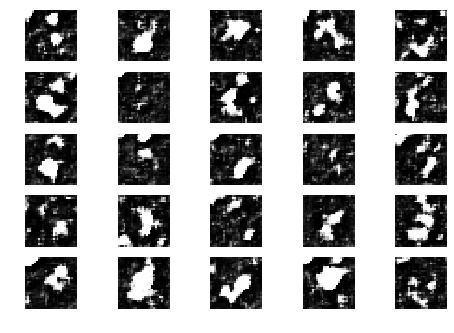

Epoch 0 Batch 451/468 [D loss: 0.008555, acc.: 100.00%] [G loss: 0.000534]
Epoch 0 Batch 452/468 [D loss: 0.001014, acc.: 100.00%] [G loss: 0.000133]
Epoch 0 Batch 453/468 [D loss: 0.002744, acc.: 100.00%] [G loss: 0.008237]
Epoch 0 Batch 454/468 [D loss: 0.001763, acc.: 100.00%] [G loss: 0.002336]
Epoch 0 Batch 455/468 [D loss: 0.000076, acc.: 100.00%] [G loss: 0.000146]
Epoch 0 Batch 456/468 [D loss: 0.000927, acc.: 100.00%] [G loss: 0.000272]
Epoch 0 Batch 457/468 [D loss: 0.000136, acc.: 100.00%] [G loss: 0.000658]
Epoch 0 Batch 458/468 [D loss: 0.001781, acc.: 100.00%] [G loss: 0.000818]
Epoch 0 Batch 459/468 [D loss: 0.000039, acc.: 100.00%] [G loss: 0.000167]
Epoch 0 Batch 460/468 [D loss: 0.309700, acc.: 90.62%] [G loss: 0.000002]
Epoch 0 Batch 461/468 [D loss: 0.032767, acc.: 96.88%] [G loss: 0.000001]
Epoch 0 Batch 462/468 [D loss: 0.016645, acc.: 100.00%] [G loss: 0.000003]
Epoch 0 Batch 463/468 [D loss: 0.017426, acc.: 100.00%] [G loss: 0.000008]
Epoch 0 Batch 464/468 [D lo

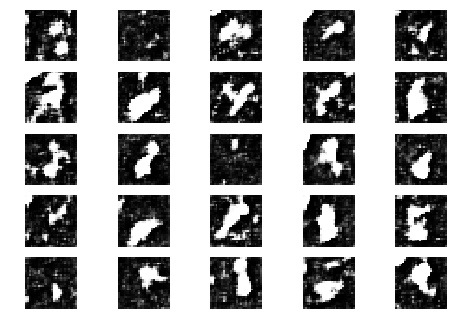

Epoch 1 Batch 1/468 [D loss: 0.000428, acc.: 100.00%] [G loss: 0.000221]
Epoch 1 Batch 2/468 [D loss: 0.060491, acc.: 96.88%] [G loss: 0.000003]
Epoch 1 Batch 3/468 [D loss: 0.027589, acc.: 100.00%] [G loss: 0.000007]
Epoch 1 Batch 4/468 [D loss: 0.015228, acc.: 100.00%] [G loss: 0.000095]
Epoch 1 Batch 5/468 [D loss: 0.004732, acc.: 100.00%] [G loss: 0.000018]
Epoch 1 Batch 6/468 [D loss: 0.001032, acc.: 100.00%] [G loss: 0.000401]
Epoch 1 Batch 7/468 [D loss: 0.000323, acc.: 100.00%] [G loss: 0.000031]
Epoch 1 Batch 8/468 [D loss: 0.012665, acc.: 100.00%] [G loss: 0.000019]
Epoch 1 Batch 9/468 [D loss: 0.000014, acc.: 100.00%] [G loss: 0.000018]
Epoch 1 Batch 10/468 [D loss: 0.000582, acc.: 100.00%] [G loss: 0.000032]
Epoch 1 Batch 11/468 [D loss: 0.017065, acc.: 100.00%] [G loss: 0.000330]
Epoch 1 Batch 12/468 [D loss: 0.020461, acc.: 100.00%] [G loss: 0.000115]
Epoch 1 Batch 13/468 [D loss: 0.022590, acc.: 100.00%] [G loss: 0.000027]
Epoch 1 Batch 14/468 [D loss: 0.000042, acc.: 10

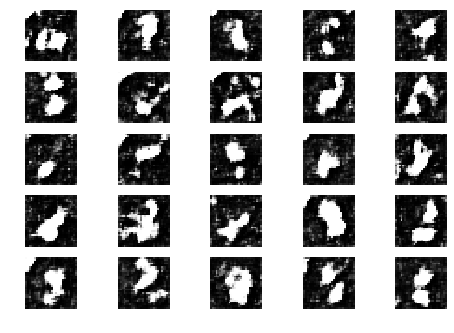

Epoch 1 Batch 51/468 [D loss: 0.000259, acc.: 100.00%] [G loss: 0.000141]
Epoch 1 Batch 52/468 [D loss: 0.000788, acc.: 100.00%] [G loss: 0.000631]
Epoch 1 Batch 53/468 [D loss: 0.035764, acc.: 96.88%] [G loss: 0.000008]
Epoch 1 Batch 54/468 [D loss: 0.010879, acc.: 100.00%] [G loss: 0.000038]
Epoch 1 Batch 55/468 [D loss: 0.006763, acc.: 100.00%] [G loss: 0.000003]
Epoch 1 Batch 56/468 [D loss: 0.000115, acc.: 100.00%] [G loss: 0.000005]
Epoch 1 Batch 57/468 [D loss: 0.000157, acc.: 100.00%] [G loss: 0.000013]
Epoch 1 Batch 58/468 [D loss: 0.000041, acc.: 100.00%] [G loss: 0.000010]
Epoch 1 Batch 59/468 [D loss: 0.000057, acc.: 100.00%] [G loss: 0.000003]
Epoch 1 Batch 60/468 [D loss: 0.011454, acc.: 100.00%] [G loss: 0.000003]
Epoch 1 Batch 61/468 [D loss: 0.000019, acc.: 100.00%] [G loss: 0.000006]
Epoch 1 Batch 62/468 [D loss: 0.000918, acc.: 100.00%] [G loss: 0.000005]
Epoch 1 Batch 63/468 [D loss: 0.001379, acc.: 100.00%] [G loss: 0.001997]
Epoch 1 Batch 64/468 [D loss: 0.000075,

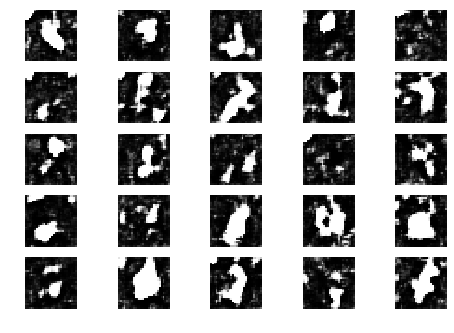

Epoch 1 Batch 101/468 [D loss: 0.003434, acc.: 100.00%] [G loss: 0.000076]
Epoch 1 Batch 102/468 [D loss: 0.002673, acc.: 100.00%] [G loss: 0.002838]
Epoch 1 Batch 103/468 [D loss: 0.000401, acc.: 100.00%] [G loss: 0.000239]
Epoch 1 Batch 104/468 [D loss: 0.004167, acc.: 100.00%] [G loss: 0.000115]
Epoch 1 Batch 105/468 [D loss: 0.001116, acc.: 100.00%] [G loss: 0.003490]
Epoch 1 Batch 106/468 [D loss: 0.001751, acc.: 100.00%] [G loss: 0.000036]
Epoch 1 Batch 107/468 [D loss: 0.000015, acc.: 100.00%] [G loss: 0.006689]
Epoch 1 Batch 108/468 [D loss: 0.012175, acc.: 100.00%] [G loss: 0.000061]
Epoch 1 Batch 109/468 [D loss: 0.000074, acc.: 100.00%] [G loss: 0.000149]
Epoch 1 Batch 110/468 [D loss: 0.000227, acc.: 100.00%] [G loss: 0.000027]
Epoch 1 Batch 111/468 [D loss: 0.001230, acc.: 100.00%] [G loss: 0.000066]
Epoch 1 Batch 112/468 [D loss: 0.003008, acc.: 100.00%] [G loss: 0.000038]
Epoch 1 Batch 113/468 [D loss: 0.008854, acc.: 100.00%] [G loss: 0.000018]
Epoch 1 Batch 114/468 [D 

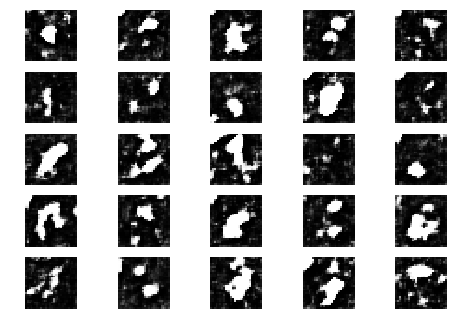

Epoch 1 Batch 151/468 [D loss: 0.001712, acc.: 100.00%] [G loss: 0.000162]
Epoch 1 Batch 152/468 [D loss: 0.013281, acc.: 100.00%] [G loss: 0.000531]
Epoch 1 Batch 153/468 [D loss: 0.020275, acc.: 100.00%] [G loss: 0.000135]
Epoch 1 Batch 154/468 [D loss: 0.001049, acc.: 100.00%] [G loss: 0.016089]
Epoch 1 Batch 155/468 [D loss: 0.001753, acc.: 100.00%] [G loss: 0.000057]
Epoch 1 Batch 156/468 [D loss: 0.001351, acc.: 100.00%] [G loss: 0.000158]
Epoch 1 Batch 157/468 [D loss: 0.010193, acc.: 100.00%] [G loss: 0.000012]
Epoch 1 Batch 158/468 [D loss: 0.000751, acc.: 100.00%] [G loss: 0.000164]
Epoch 1 Batch 159/468 [D loss: 0.000257, acc.: 100.00%] [G loss: 0.000040]
Epoch 1 Batch 160/468 [D loss: 0.003280, acc.: 100.00%] [G loss: 0.000003]
Epoch 1 Batch 161/468 [D loss: 0.010868, acc.: 100.00%] [G loss: 0.001229]
Epoch 1 Batch 162/468 [D loss: 0.000388, acc.: 100.00%] [G loss: 0.000277]
Epoch 1 Batch 163/468 [D loss: 0.000592, acc.: 100.00%] [G loss: 0.000029]
Epoch 1 Batch 164/468 [D 

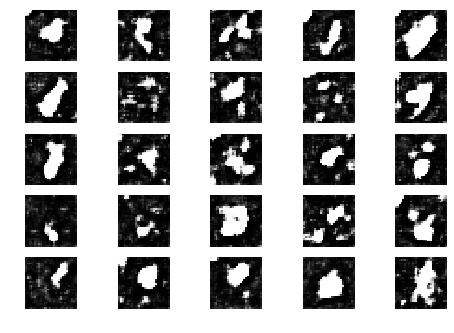

Epoch 1 Batch 201/468 [D loss: 0.004613, acc.: 100.00%] [G loss: 0.000073]
Epoch 1 Batch 202/468 [D loss: 0.002069, acc.: 100.00%] [G loss: 0.000151]
Epoch 1 Batch 203/468 [D loss: 0.000724, acc.: 100.00%] [G loss: 0.001853]
Epoch 1 Batch 204/468 [D loss: 0.000012, acc.: 100.00%] [G loss: 0.001885]
Epoch 1 Batch 205/468 [D loss: 0.012313, acc.: 100.00%] [G loss: 0.000076]
Epoch 1 Batch 206/468 [D loss: 0.001389, acc.: 100.00%] [G loss: 0.056174]
Epoch 1 Batch 207/468 [D loss: 0.005440, acc.: 100.00%] [G loss: 0.000782]
Epoch 1 Batch 208/468 [D loss: 0.001006, acc.: 100.00%] [G loss: 0.010930]
Epoch 1 Batch 209/468 [D loss: 0.121921, acc.: 96.88%] [G loss: 0.000111]
Epoch 1 Batch 210/468 [D loss: 0.012745, acc.: 100.00%] [G loss: 0.000245]
Epoch 1 Batch 211/468 [D loss: 0.000297, acc.: 100.00%] [G loss: 0.000007]
Epoch 1 Batch 212/468 [D loss: 0.069411, acc.: 100.00%] [G loss: 0.000327]
Epoch 1 Batch 213/468 [D loss: 0.001744, acc.: 100.00%] [G loss: 0.002958]
Epoch 1 Batch 214/468 [D l

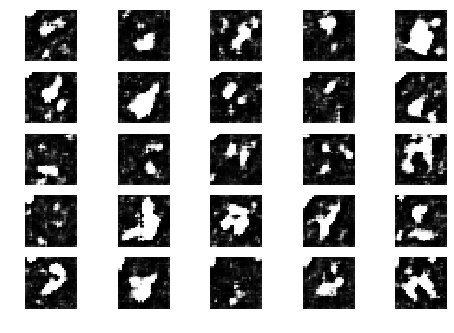

Epoch 1 Batch 251/468 [D loss: 0.000653, acc.: 100.00%] [G loss: 0.002156]
Epoch 1 Batch 252/468 [D loss: 0.165350, acc.: 90.62%] [G loss: 0.000003]
Epoch 1 Batch 253/468 [D loss: 0.030196, acc.: 96.88%] [G loss: 0.000002]
Epoch 1 Batch 254/468 [D loss: 0.000839, acc.: 100.00%] [G loss: 0.000002]
Epoch 1 Batch 255/468 [D loss: 0.000682, acc.: 100.00%] [G loss: 0.000123]
Epoch 1 Batch 256/468 [D loss: 0.034226, acc.: 96.88%] [G loss: 0.000041]
Epoch 1 Batch 257/468 [D loss: 0.000030, acc.: 100.00%] [G loss: 0.000109]
Epoch 1 Batch 258/468 [D loss: 0.000220, acc.: 100.00%] [G loss: 0.000044]
Epoch 1 Batch 259/468 [D loss: 1.442523, acc.: 71.88%] [G loss: 0.238515]
Epoch 1 Batch 260/468 [D loss: 1.895799, acc.: 56.25%] [G loss: 0.003795]
Epoch 1 Batch 261/468 [D loss: 0.203563, acc.: 93.75%] [G loss: 0.004156]
Epoch 1 Batch 262/468 [D loss: 0.022421, acc.: 100.00%] [G loss: 0.000015]
Epoch 1 Batch 263/468 [D loss: 0.005772, acc.: 100.00%] [G loss: 0.000119]
Epoch 1 Batch 264/468 [D loss: 

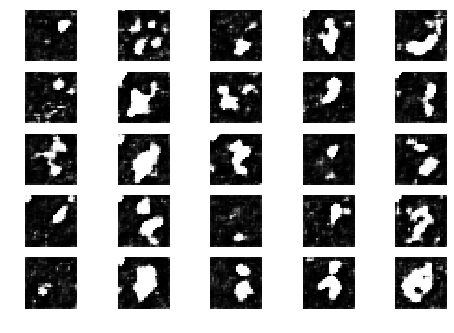

Epoch 1 Batch 301/468 [D loss: 0.002441, acc.: 100.00%] [G loss: 0.000038]
Epoch 1 Batch 302/468 [D loss: 0.001619, acc.: 100.00%] [G loss: 0.000276]
Epoch 1 Batch 303/468 [D loss: 0.004537, acc.: 100.00%] [G loss: 0.000937]
Epoch 1 Batch 304/468 [D loss: 0.000075, acc.: 100.00%] [G loss: 0.000127]
Epoch 1 Batch 305/468 [D loss: 0.000047, acc.: 100.00%] [G loss: 0.000067]
Epoch 1 Batch 306/468 [D loss: 0.000601, acc.: 100.00%] [G loss: 0.000019]
Epoch 1 Batch 307/468 [D loss: 0.000856, acc.: 100.00%] [G loss: 0.000252]
Epoch 1 Batch 308/468 [D loss: 0.001146, acc.: 100.00%] [G loss: 0.000457]
Epoch 1 Batch 309/468 [D loss: 0.000613, acc.: 100.00%] [G loss: 0.000050]
Epoch 1 Batch 310/468 [D loss: 0.000396, acc.: 100.00%] [G loss: 0.000181]
Epoch 1 Batch 311/468 [D loss: 0.000257, acc.: 100.00%] [G loss: 0.000141]
Epoch 1 Batch 312/468 [D loss: 0.000073, acc.: 100.00%] [G loss: 0.000134]
Epoch 1 Batch 313/468 [D loss: 0.000080, acc.: 100.00%] [G loss: 0.000026]
Epoch 1 Batch 314/468 [D 

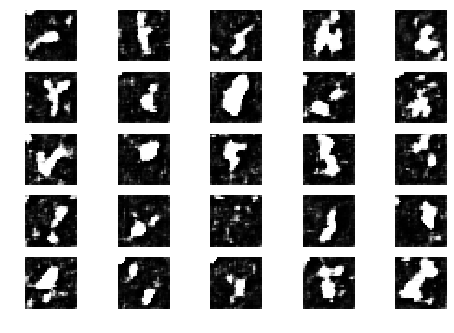

Epoch 1 Batch 351/468 [D loss: 0.003261, acc.: 100.00%] [G loss: 0.000026]
Epoch 1 Batch 352/468 [D loss: 0.000956, acc.: 100.00%] [G loss: 0.000004]
Epoch 1 Batch 353/468 [D loss: 0.021677, acc.: 100.00%] [G loss: 0.000089]
Epoch 1 Batch 354/468 [D loss: 0.001512, acc.: 100.00%] [G loss: 0.000083]
Epoch 1 Batch 355/468 [D loss: 0.000536, acc.: 100.00%] [G loss: 0.000037]
Epoch 1 Batch 356/468 [D loss: 0.015029, acc.: 100.00%] [G loss: 0.000042]
Epoch 1 Batch 357/468 [D loss: 0.000038, acc.: 100.00%] [G loss: 0.000191]
Epoch 1 Batch 358/468 [D loss: 0.000484, acc.: 100.00%] [G loss: 0.000035]
Epoch 1 Batch 359/468 [D loss: 0.000245, acc.: 100.00%] [G loss: 0.000007]
Epoch 1 Batch 360/468 [D loss: 0.000089, acc.: 100.00%] [G loss: 0.000075]
Epoch 1 Batch 361/468 [D loss: 0.000059, acc.: 100.00%] [G loss: 0.000089]
Epoch 1 Batch 362/468 [D loss: 0.000045, acc.: 100.00%] [G loss: 0.052971]
Epoch 1 Batch 363/468 [D loss: 0.000197, acc.: 100.00%] [G loss: 0.000635]
Epoch 1 Batch 364/468 [D 

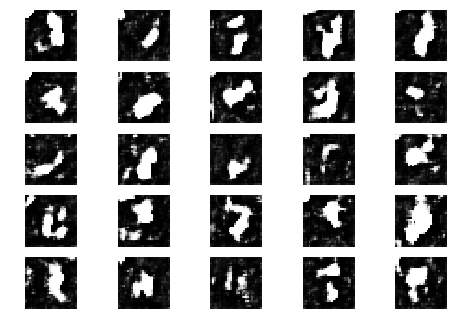

Epoch 1 Batch 401/468 [D loss: 0.000545, acc.: 100.00%] [G loss: 0.000015]
Epoch 1 Batch 402/468 [D loss: 0.000068, acc.: 100.00%] [G loss: 0.000057]
Epoch 1 Batch 403/468 [D loss: 0.000065, acc.: 100.00%] [G loss: 0.000004]
Epoch 1 Batch 404/468 [D loss: 0.001195, acc.: 100.00%] [G loss: 0.000012]
Epoch 1 Batch 405/468 [D loss: 0.000017, acc.: 100.00%] [G loss: 0.000025]
Epoch 1 Batch 406/468 [D loss: 0.001422, acc.: 100.00%] [G loss: 0.000076]
Epoch 1 Batch 407/468 [D loss: 0.000219, acc.: 100.00%] [G loss: 0.000084]
Epoch 1 Batch 408/468 [D loss: 0.000795, acc.: 100.00%] [G loss: 0.000019]
Epoch 1 Batch 409/468 [D loss: 0.000098, acc.: 100.00%] [G loss: 0.000621]
Epoch 1 Batch 410/468 [D loss: 0.000050, acc.: 100.00%] [G loss: 0.000028]
Epoch 1 Batch 411/468 [D loss: 0.000864, acc.: 100.00%] [G loss: 0.000006]
Epoch 1 Batch 412/468 [D loss: 0.000031, acc.: 100.00%] [G loss: 0.000037]
Epoch 1 Batch 413/468 [D loss: 0.003877, acc.: 100.00%] [G loss: 0.000073]
Epoch 1 Batch 414/468 [D 

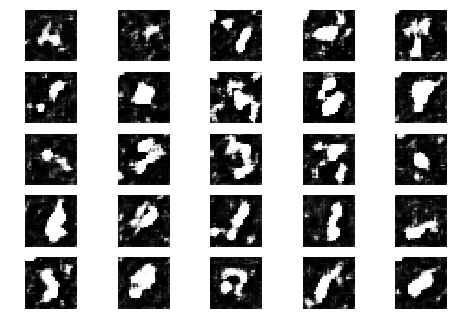

Epoch 1 Batch 451/468 [D loss: 0.000592, acc.: 100.00%] [G loss: 0.000018]
Epoch 1 Batch 452/468 [D loss: 0.022573, acc.: 100.00%] [G loss: 0.000116]
Epoch 1 Batch 453/468 [D loss: 0.000843, acc.: 100.00%] [G loss: 0.000179]
Epoch 1 Batch 454/468 [D loss: 0.000092, acc.: 100.00%] [G loss: 0.000144]
Epoch 1 Batch 455/468 [D loss: 0.000043, acc.: 100.00%] [G loss: 0.000002]
Epoch 1 Batch 456/468 [D loss: 0.000089, acc.: 100.00%] [G loss: 0.000051]
Epoch 1 Batch 457/468 [D loss: 0.000212, acc.: 100.00%] [G loss: 0.000080]
Epoch 1 Batch 458/468 [D loss: 0.000149, acc.: 100.00%] [G loss: 0.000383]
Epoch 1 Batch 459/468 [D loss: 0.000653, acc.: 100.00%] [G loss: 0.000045]
Epoch 1 Batch 460/468 [D loss: 0.000028, acc.: 100.00%] [G loss: 0.000003]
Epoch 1 Batch 461/468 [D loss: 0.000007, acc.: 100.00%] [G loss: 0.000066]
Epoch 1 Batch 462/468 [D loss: 0.015461, acc.: 100.00%] [G loss: 0.000016]
Epoch 1 Batch 463/468 [D loss: 0.003211, acc.: 100.00%] [G loss: 0.000009]
Epoch 1 Batch 464/468 [D 

In [55]:
train(generator1, generator2,  discriminator, combined,   epochs=1, batch_size=32, save_interval=1)

In [0]:
    generator1.save('generator1.h5')
    discriminator.save('discriminator1.h5')
    combined.save('combined1.h5')

In [0]:
files.download('generator1.h5')

In [0]:
files.download('discriminator1.h5')

In [0]:
files.download('combined1.h5')

In [0]:
generator1 = load_model('generator1.h5')
discriminator1 = load_model('discriminator1.h5')
combined1 = load_model('combined1.h5')

